# CNN & MNIST Hand-Written Number Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%env KERAS_BACKEND = tensorflow
%matplotlib inline

In [2]:
from keras.datasets import mnist
from keras.layers import Dense, Activation, Flatten, Input, Conv2D, MaxPool2D, concatenate
from keras.models import Model
from keras.utils import np_utils
from keras import optimizers, losses
from keras.layers.core import Lambda
from ipywidgets import interact_manual, fixed

import keras.backend as K

Using TensorFlow backend.


env: KERAS_BACKEND=tensorflow


### 用 CNN 前，要先把維度 (28,28)(經過 normalized )的訓練及測試資料reshape成(28,28,1)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_normalized = x_train/x_train.max()
x_test_normalized = x_test/x_test.max()
x_train_cnn = x_train_normalized.reshape(len(x_train), 28, 28, 1)
x_test_cnn = x_test_normalized.reshape(len(x_test), 28, 28, 1)

### One-Hot Encode

In [4]:
y_train_one_hot = np_utils.to_categorical(y_train, 10)
y_test_one_hot = np_utils.to_categorical(y_test,10)

### 用來做 interact_manual 的畫圖函數

In [5]:
def WRONG_CLASSIFICATION(name, y_wrong_predict, x_wrong_predict, number=0): 
    # (machine name in the title, the number classified by wrong prediction, 
    #  the corresponding figure, the number you want to look at)
    length = len(y_wrong_predict[number])
    height = np.ceil(length/10).astype(np.int32)  
    figure = plt.figure(figsize=(100,10*height), dpi=100)   # set the size of figure, which should cotain 10 column if wrong prediction is more than 10
    
    if (length>10):
        width = 10
        title_shift = 1.1 # for layout adjustment
    else:
        width = length
        title_shift = 1.3 # for layout adjustment
    
    for i in range(0, length):
        ax = figure.add_subplot(height, width, i+1 )
        ax.imshow(x_wrong_predict[number][i], cmap='Greys')
        ax.axis('off')
        ax.set_title('Classified as %d' %y_wrong_predict[number][i],fontsize=60, color='red')  # put on the title for subplots
    
    figure.suptitle('Wrong Classification of %d for $%s$ Machince' %(number,name), fontsize=200, y=title_shift)  # put on the title for the figure
    plt.show() 
    

### 用自行定義的神經元做 normalized layer，可以把被 filters 濾過並經過 pooling 縮減過的矩陣 normalized 到 \[0,1\] 

In [6]:
def NORMALIZED(inputs):
    return (inputs)/(K.max(inputs)-K.min(inputs))

normalized_layer_1 = Lambda(NORMALIZED)
normalized_layer_2 = Lambda(NORMALIZED)
normalized_layer_3 = Lambda(NORMALIZED)
normalized_layer_4 = Lambda(NORMALIZED)

### 定義 Input

In [7]:
x = Input(shape=(28,28,1))

### 用 Functioal API 設計神經網路:
這邊及之後 5 個網路用的主架構都大同小異(差在有沒有加 normalized layer 及 optimizer, losses, activation 及將濾鏡數由小到大改成由大到小)，均由三個單元組成，每個單元有:  3 個不同的 filter 過濾 input (有點調皮想試試看不是方形的濾鏡) ，濾完之後concatenate，再經過 pooling。重複三次(但每個單元 filter 數目不同)後flatten,再經一層 Dense 連到 output。每個網路訓練的 epcho 累積起來都是 45 次，binsize 則是 200。 

### Model 1<sup>st</sup>

In [8]:
Cv_1 = Conv2D(2,(2,4), padding = 'same', input_shape = (28,28,1), activation='relu')
Ch_1 = Conv2D(2,(4,2), padding = 'same', input_shape = (28,28,1), activation='relu')
Cs_1 = Conv2D(2,(3,3), padding = 'same', input_shape = (28,28,1), activation='relu')
P_1 = (MaxPool2D(pool_size=(2,2)))

Cv_2 = Conv2D(4,(2,4), padding = 'same', activation='relu')
Ch_2 = Conv2D(4,(4,2), padding = 'same', activation='relu')
Cs_2 = Conv2D(4,(3,3), padding = 'same', activation='relu')
P_2 = (MaxPool2D(pool_size=(2,2)))

Cv_3 = Conv2D(8,(2,4), padding = 'same', activation='relu')
Ch_3 = Conv2D(8,(4,2), padding = 'same', activation='relu')
Cs_3 = Conv2D(8,(3,3), padding = 'same', activation='relu')
P_3 = (MaxPool2D(pool_size=(2,2)))

F_1 = Flatten()
D_1 = Dense(9, activation='relu')
Output = Dense(10, activation='softmax')

In [9]:
v_1 = Cv_1(x)
h_1 = Ch_1(x)
s_1 = Cs_1(x)
L_1 = concatenate([v_1, h_1, s_1])
PL_1 = P_1(L_1)

v_2 = Cv_2(PL_1)
h_2 = Ch_2(PL_1)
s_2 = Cs_2(PL_1)
L_2 = concatenate([v_2, h_2, s_2])
PL_2 = P_2(L_2)

v_3 = Cv_3(PL_2)
h_3 = Ch_3(PL_2)
s_3 = Cs_3(PL_2)
L_3 = concatenate([v_3, h_3, s_3])
PL_3 = P_3(L_3)

f_1 = F_1(PL_3)
d_1 = D_1(f_1)
output = Output(d_1)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model_1st = Model(x,output)
model_1st.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 2)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

In [12]:
model_1st.load_weights('./MNIST_CNN_Machines/CNN_1st_machine_weights.h5')
model_1 = model_1st.compile( optimizers.sgd(lr = 0.05),losses.categorical_crossentropy, metrics=['acc'])
#model_1_his = model_1st.fit(x_train_cnn, y_train_one_hot, batch_size=100, epochs=45)

In [45]:
#model_1st_json = model_1st.to_json()
#open('./MNIST_CNN_Machines/CNN_1st_machine','w').write(model_1st_json)
#model_1st.save_weights('./MNIST_CNN_Machines/CNN_1st_machine_weights.h5')

In [46]:
model_1st_score_train = model_1st.evaluate(x_train_cnn, y_train_one_hot)
model_1st_score_test = model_1st.evaluate(x_test_cnn, y_test_one_hot)

y_1st_predict_one_hot = model_1st.predict(x_test_cnn)

10000/10000 [==============================] - 6s 628us/step


### 訓練及測試資料的準確率
看起來還不錯，訓練資料 99.2% ，測試資料有到 98.6% 。

In [47]:
print(f'For Training Data: Loss = {model_1st_score_train[0]:.6f}; Accuracy = {100*model_1st_score_train[1]:.6f}%')
print(f'For Testing Data: Loss = {model_1st_score_test[0]:.6f}; Accuracy = {100*model_1st_score_test[1]:.6f}%')

For Training Data: Loss = 0.022768; Accuracy = 99.226667%
For Testing Data: Loss = 0.054657; Accuracy = 98.610000%


### 看一下 Confusion Matrix
非對角線幾乎是個位數，似乎還不錯。

In [48]:
y_1st_predict = np.zeros(len(y_test)).astype(np.int32)
for i in range(0, len(y_test)):
    y_1st_predict[i] = y_1st_predict_one_hot[i].argmax()
pd.crosstab(y_test, y_1st_predict, rownames=['Ture Number'], colnames=['Predict Number'])

Predict Number,0,1,2,3,4,5,6,7,8,9
Ture Number,,,,,,,,,,
0,972,1,0,0,1,1,3,1,1,0
1,0,1131,3,0,0,0,0,0,1,0
2,1,1,1016,2,3,0,0,4,5,0
3,0,0,1,1001,0,3,0,2,3,0
4,0,1,0,0,974,0,1,1,2,3
5,1,0,0,3,1,882,1,0,2,2
6,4,4,0,0,3,3,941,0,3,0
7,0,4,9,1,0,1,0,1007,0,6
8,1,1,0,1,1,5,1,1,961,2


### 用 interact_manual 選擇想要看的數字，可以對照神經網路判斷錯誤的資料的原圖

In [49]:
y_wrong_predict_1st = []
x_wrong_predict_1st = []

for i in range(0,10):
    TF = (y_test==i) &(y_1st_predict!=y_test)
    y_wrong_predict_1st.append(y_1st_predict[TF])
    x_wrong_predict_1st.append(x_test[TF])
    
interact_manual(WRONG_CLASSIFICATION, name=fixed('1^{st}'),
                y_wrong_predict=fixed(y_wrong_predict_1st), x_wrong_predict=fixed(x_wrong_predict_1st),
               number=range(0,10) );

interactive(children=(Dropdown(description='number', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Button(…

### Model 2<sup>nd</sup>
這次每個單元最後面都加了 normalized layer ，再輸進最後的 Dense 層也給他 normalized 一下。

In [34]:
Cv_1 = Conv2D(2,(2,4), padding = 'same', input_shape = (28,28,1), activation='relu')
Ch_1 = Conv2D(2,(4,2), padding = 'same', input_shape = (28,28,1), activation='relu')
Cs_1 = Conv2D(2,(3,3), padding = 'same', input_shape = (28,28,1), activation='relu')
P_1 = (MaxPool2D(pool_size=(2,2)))

Cv_2 = Conv2D(4,(2,4), padding = 'same', activation='relu')
Ch_2 = Conv2D(4,(4,2), padding = 'same', activation='relu')
Cs_2 = Conv2D(4,(3,3), padding = 'same', activation='relu')
P_2 = (MaxPool2D(pool_size=(2,2)))

Cv_3 = Conv2D(8,(2,4), padding = 'same', activation='relu')
Ch_3 = Conv2D(8,(4,2), padding = 'same', activation='relu')
Cs_3 = Conv2D(8,(3,3), padding = 'same', activation='relu')
P_3 = (MaxPool2D(pool_size=(2,2)))

F_1 = Flatten()
D_1 = Dense(9, activation='relu')
Output = Dense(10, activation='softmax')

In [35]:
v_1 = Cv_1(x)
h_1 = Ch_1(x)
s_1 = Cs_1(x)
L_1 = concatenate([v_1, h_1, s_1])
PL_1 = P_1(L_1)
N_1 = normalized_layer_1(PL_1)

v_2 = Cv_2(N_1)
h_2 = Ch_2(N_1)
s_2 = Cs_2(N_1)
L_2 = concatenate([v_2, h_2, s_2])
PL_2 = P_2(L_2)
N_2 = normalized_layer_2(PL_2)

v_3 = Cv_3(N_2)
h_3 = Ch_3(N_2)
s_3 = Cs_3(N_2)
L_3 = concatenate([v_3, h_3, s_3])
PL_3 = P_3(L_3)
N_3 = normalized_layer_3(PL_3)

f_1 = F_1(N_3)
N_4 = normalized_layer_4(f_1)
d_1 = D_1(N_4)
output = Output(d_1)

In [36]:
model_2nd = Model(x,output)
model_2nd.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 28, 28, 2)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

In [37]:
model_2nd.load_weights('./MNIST_CNN_Machines/CNN_2nd_machine_weights.h5')
model_2 = model_2nd.compile( optimizers.sgd(lr = 0.05),losses.categorical_crossentropy, metrics=['acc'])
#model_2_his = model_2nd.fit(x_train_cnn, y_train_one_hot, batch_size=100, epochs=45)

Epoch 1/45
60000/60000 [==============================] - 62s 1ms/step - loss: 1.2368 - acc: 0.6485
Epoch 2/45
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2928 - acc: 0.9225
Epoch 3/45
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1737 - acc: 0.9514
Epoch 4/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1321 - acc: 0.9628
Epoch 5/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1101 - acc: 0.9681
Epoch 6/45
60000/60000 [==============================] - 63s 1ms/step - loss: 0.0952 - acc: 0.9727
Epoch 7/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0853 - acc: 0.9750
Epoch 8/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0785 - acc: 0.9770
Epoch 9/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0714 - acc: 0.9793
Epoch 10/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0658 - acc: 0.9809

In [50]:
#model_2nd_json = model_2nd.to_json()
#open('./MNIST_CNN_Machines/CNN_2nd_machine','w').write(model_2nd_json)
#model_2nd.save_weights('./MNIST_CNN_Machines/CNN_2nd_machine_weights.h5')

In [38]:
model_2nd_score_train = model_2nd.evaluate(x_train_cnn, y_train_one_hot)
model_2nd_score_test = model_2nd.evaluate(x_test_cnn, y_test_one_hot)

y_2nd_predict_one_hot = model_2nd.predict(x_test_cnn)

10000/10000 [==============================] - 7s 739us/step


### 訓練及測試資料的正確率
比 Model 1<sup>st</sup> 又稍微好一點，訓練到 99.47%，測試也有98.88%。

In [39]:
print(f'For Training Data: Loss = {model_2nd_score_train[0]:.6f}; Accuracy = {100*model_2nd_score_train[1]:.6f}%')
print(f'For Testing Data: Loss = {model_2nd_score_test[0]:.6f}; Accuracy = {100*model_2nd_score_test[1]:.6f}%')

For Training Data: Loss = 0.018801; Accuracy = 99.470000%
For Testing Data: Loss = 0.036967; Accuracy = 98.880000%


### Confusion Matrix
非對角線元素壓在個位數以內，雖然對3, 4, 5, 6, 8 的辨識能力稍微下降，但7跟9的辨識能力有顯著提升。

In [40]:
y_2nd_predict = np.zeros(len(y_test)).astype(np.int32)
for i in range(0, len(y_test)):
    y_2nd_predict[i] = y_2nd_predict_one_hot[i].argmax()
pd.crosstab(y_test, y_2nd_predict, rownames=['Ture Number'], colnames=['Predict Number'])

Predict Number,0,1,2,3,4,5,6,7,8,9
Ture Number,,,,,,,,,,
0,973,0,1,0,0,1,4,1,0,0
1,0,1133,0,0,1,0,0,1,0,0
2,4,3,1019,2,0,0,0,3,1,0
3,0,0,1,1000,0,4,0,3,1,1
4,1,0,0,0,971,0,1,1,0,8
5,2,0,0,7,0,880,1,1,1,0
6,6,5,0,0,2,3,940,0,2,0
7,0,4,3,1,0,0,0,1018,1,1
8,2,1,5,3,1,1,0,1,958,2


### 一樣做個互動看一下那些資料認不出來

In [51]:
y_wrong_predict_2nd = []
x_wrong_predict_2nd = []

for i in range(0,10):
    TF = (y_test==i) &(y_2nd_predict!=y_test)
    y_wrong_predict_2nd.append(y_2nd_predict[TF])
    x_wrong_predict_2nd.append(x_test[TF])
    
interact_manual(WRONG_CLASSIFICATION, name=fixed('2^{nd}'),
                y_wrong_predict=fixed(y_wrong_predict_2nd), x_wrong_predict=fixed(x_wrong_predict_2nd),
               number=range(0,10) );

interactive(children=(Dropdown(description='number', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Button(…

### Model 3<sup>rd</sup>
結構跟 Model 2<sup>nd</sup> 一模一樣，不過改用 adam 當 optimizer。

In [52]:
Cv_1 = Conv2D(2,(2,4), padding = 'same', input_shape = (28,28,1), activation='relu')
Ch_1 = Conv2D(2,(4,2), padding = 'same', input_shape = (28,28,1), activation='relu')
Cs_1 = Conv2D(2,(3,3), padding = 'same', input_shape = (28,28,1), activation='relu')
P_1 = (MaxPool2D(pool_size=(2,2)))

Cv_2 = Conv2D(4,(2,4), padding = 'same', activation='relu')
Ch_2 = Conv2D(4,(4,2), padding = 'same', activation='relu')
Cs_2 = Conv2D(4,(3,3), padding = 'same', activation='relu')
P_2 = (MaxPool2D(pool_size=(2,2)))

Cv_3 = Conv2D(8,(2,4), padding = 'same', activation='relu')
Ch_3 = Conv2D(8,(4,2), padding = 'same', activation='relu')
Cs_3 = Conv2D(8,(3,3), padding = 'same', activation='relu')
P_3 = (MaxPool2D(pool_size=(2,2)))

F_1 = Flatten()
D_1 = Dense(9, activation='relu')
Output = Dense(10, activation='softmax')

v_1 = Cv_1(x)
h_1 = Ch_1(x)
s_1 = Cs_1(x)
L_1 = concatenate([v_1, h_1, s_1])
PL_1 = P_1(L_1)
N_1 = normalized_layer_1(PL_1)

v_2 = Cv_2(N_1)
h_2 = Ch_2(N_1)
s_2 = Cs_2(N_1)
L_2 = concatenate([v_2, h_2, s_2])
PL_2 = P_2(L_2)
N_2 = normalized_layer_2(PL_2)

v_3 = Cv_3(N_2)
h_3 = Ch_3(N_2)
s_3 = Cs_3(N_2)
L_3 = concatenate([v_3, h_3, s_3])
PL_3 = P_3(L_3)
N_3 = normalized_layer_3(PL_3)

f_1 = F_1(N_3)
N_4 = normalized_layer_4(f_1)
d_1 = D_1(N_4)
output = Output(d_1)

In [53]:
model_3rd = Model(x,output)
model_3rd.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 28, 28, 2)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

In [54]:
#model_3rd.load_weights('./MNIST_CNN_Machines/CNN_3rd_machine_weights.h5')
model_3 = model_3rd.compile( optimizers.adam(lr = 0.05),losses.categorical_crossentropy, metrics=['acc'])
model_3_his = model_3rd.fit(x_train_cnn, y_train_one_hot, batch_size=100, epochs=45)

Epoch 1/45
60000/60000 [==============================] - 65s 1ms/step - loss: 1.0490 - acc: 0.6288
Epoch 2/45
60000/60000 [==============================] - 60s 1ms/step - loss: 0.5318 - acc: 0.8365
Epoch 3/45
60000/60000 [==============================] - 60s 992us/step - loss: 0.4618 - acc: 0.8661
Epoch 4/45
60000/60000 [==============================] - 60s 993us/step - loss: 0.4333 - acc: 0.8766
Epoch 5/45
60000/60000 [==============================] - 60s 992us/step - loss: 0.4167 - acc: 0.8818
Epoch 6/45
60000/60000 [==============================] - 65s 1ms/step - loss: 0.4053 - acc: 0.8861
Epoch 7/45
60000/60000 [==============================] - 59s 991us/step - loss: 0.3999 - acc: 0.8873
Epoch 8/45
60000/60000 [==============================] - 60s 999us/step - loss: 0.3874 - acc: 0.8909
Epoch 9/45
60000/60000 [==============================] - 61s 1ms/step - loss: 0.3825 - acc: 0.8927
Epoch 10/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.3798 - a

In [55]:
#model_3rd_json = model_3rd.to_json()
#open('./MNIST_CNN_Machines/CNN_3rd_machine','w').write(model_3rd_json)
#model_3rd.save_weights('./MNIST_CNN_Machines/CNN_3rd_machine_weights.h5')

表現似乎沒有 sgd 那麼優。

In [56]:
model_3rd_score_train = model_3rd.evaluate(x_train_cnn, y_train_one_hot)
model_3rd_score_test = model_3rd.evaluate(x_test_cnn, y_test_one_hot)
y_3rd_predict_one_hot = model_3rd.predict(x_test_cnn)
print(f'For Training Data: Loss = {model_3rd_score_train[0]:.6f}; Accuracy = {100*model_3rd_score_train[1]:.6f}%')
print(f'For Testing Data: Loss = {model_3rd_score_test[0]:.6f}; Accuracy = {100*model_3rd_score_test[1]:.6f}%')

y_3rd_predict = np.zeros(len(y_test)).astype(np.int32)
for i in range(0, len(y_test)):
    y_3rd_predict[i] = y_3rd_predict_one_hot[i].argmax()
pd.crosstab(y_test, y_3rd_predict, rownames=['Ture Number'], colnames=['Predict Number'])

10000/10000 [==============================] - 6s 621us/step
For Training Data: Loss = 0.314871; Accuracy = 91.390000%
For Testing Data: Loss = 0.315321; Accuracy = 91.480000%


Predict Number,0,1,2,3,4,5,6,7,8,9
Ture Number,,,,,,,,,,
0,940,0,0,0,0,6,12,0,22,0
1,0,1084,33,10,0,0,0,8,0,0
2,0,25,948,23,0,0,15,0,21,0
3,0,9,17,944,10,5,0,4,15,6
4,0,0,3,25,873,2,1,29,7,42
5,15,0,2,9,0,790,1,0,51,24
6,24,0,8,1,0,0,904,0,21,0
7,0,48,6,24,54,0,0,893,1,2
8,25,0,19,41,1,18,16,0,849,5


In [57]:
y_wrong_predict_3rd = []
x_wrong_predict_3rd = []

for i in range(0,10):
    TF = (y_test==i) &(y_3rd_predict!=y_test)
    y_wrong_predict_3rd.append(y_3rd_predict[TF])
    x_wrong_predict_3rd.append(x_test[TF])
    
interact_manual(WRONG_CLASSIFICATION, name=fixed('3^{rd}'),
                y_wrong_predict=fixed(y_wrong_predict_3rd), x_wrong_predict=fixed(x_wrong_predict_3rd),
               number=range(0,10) );

interactive(children=(Dropdown(description='number', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Button(…

### Model 4<sup>th</sup>
跟 Model 2<sup>nd</sup> 一樣，loss 改用mse 。

In [58]:
Cv_1 = Conv2D(2,(2,4), padding = 'same', input_shape = (28,28,1), activation='relu')
Ch_1 = Conv2D(2,(4,2), padding = 'same', input_shape = (28,28,1), activation='relu')
Cs_1 = Conv2D(2,(3,3), padding = 'same', input_shape = (28,28,1), activation='relu')
P_1 = (MaxPool2D(pool_size=(2,2)))

Cv_2 = Conv2D(4,(2,4), padding = 'same', activation='relu')
Ch_2 = Conv2D(4,(4,2), padding = 'same', activation='relu')
Cs_2 = Conv2D(4,(3,3), padding = 'same', activation='relu')
P_2 = (MaxPool2D(pool_size=(2,2)))

Cv_3 = Conv2D(8,(2,4), padding = 'same', activation='relu')
Ch_3 = Conv2D(8,(4,2), padding = 'same', activation='relu')
Cs_3 = Conv2D(8,(3,3), padding = 'same', activation='relu')
P_3 = (MaxPool2D(pool_size=(2,2)))

F_1 = Flatten()
D_1 = Dense(9, activation='relu')
Output = Dense(10, activation='softmax')

v_1 = Cv_1(x)
h_1 = Ch_1(x)
s_1 = Cs_1(x)
L_1 = concatenate([v_1, h_1, s_1])
PL_1 = P_1(L_1)
N_1 = normalized_layer_1(PL_1)

v_2 = Cv_2(N_1)
h_2 = Ch_2(N_1)
s_2 = Cs_2(N_1)
L_2 = concatenate([v_2, h_2, s_2])
PL_2 = P_2(L_2)
N_2 = normalized_layer_2(PL_2)

v_3 = Cv_3(N_2)
h_3 = Ch_3(N_2)
s_3 = Cs_3(N_2)
L_3 = concatenate([v_3, h_3, s_3])
PL_3 = P_3(L_3)
N_3 = normalized_layer_3(PL_3)

f_1 = F_1(N_3)
N_4 = normalized_layer_4(f_1)
d_1 = D_1(N_4)
output = Output(d_1)

In [59]:
model_4th = Model(x,output)
model_4th.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 28, 28, 2)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

In [60]:
model_4th.load_weights('./MNIST_CNN_Machines/CNN_4th_machine_weights.h5')
model_4 = model_4th.compile( optimizers.sgd(lr = 0.05),losses.mse, metrics=['acc'])
#model_4_his = model_4th.fit(x_train_cnn, y_train_one_hot, batch_size=100, epochs=45)

Epoch 1/45
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0897 - acc: 0.2021
Epoch 2/45
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0887 - acc: 0.2449
Epoch 3/45
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0875 - acc: 0.2361
Epoch 4/45
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0858 - acc: 0.2257
Epoch 5/45
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0833 - acc: 0.2215
Epoch 6/45
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0804 - acc: 0.2318
Epoch 7/45
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0778 - acc: 0.2763
Epoch 8/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0755 - acc: 0.3254
Epoch 9/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0729 - acc: 0.3909
Epoch 10/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0697 - acc: 0.4546

In [66]:
#model_4th_json = model_4th.to_json()
#open('./MNIST_CNN_Machines/CNN_4th_machine','w').write(model_4th_json)
#model_4th.save_weights('./MNIST_CNN_Machines/CNN_4th_machine_weights.h5')

In [61]:
model_4th_score_train = model_4th.evaluate(x_train_cnn, y_train_one_hot)
model_4th_score_test = model_4th.evaluate(x_test_cnn, y_test_one_hot)
y_4th_predict_one_hot = model_4th.predict(x_test_cnn)
print(f'For Training Data: Loss = {model_4th_score_train[0]:.6f}; Accuracy = {100*model_4th_score_train[1]:.6f}%')
print(f'For Testing Data: Loss = {model_4th_score_test[0]:.6f}; Accuracy = {100*model_4th_score_test[1]:.6f}%')

y_4th_predict = np.zeros(len(y_test)).astype(np.int32)
for i in range(0, len(y_test)):
    y_4th_predict[i] = y_4th_predict_one_hot[i].argmax()
pd.crosstab(y_test, y_4th_predict, rownames=['Ture Number'], colnames=['Predict Number'])

10000/10000 [==============================] - 7s 701us/step
For Training Data: Loss = 0.007578; Accuracy = 95.755000%
For Testing Data: Loss = 0.006968; Accuracy = 96.280000%


Predict Number,0,1,2,3,4,5,6,7,8,9
Ture Number,,,,,,,,,,
0,964,0,4,0,0,0,5,1,6,0
1,0,1118,5,3,1,0,3,0,5,0
2,14,2,990,1,6,0,3,7,9,0
3,2,0,10,977,0,5,0,7,6,3
4,0,1,3,0,956,0,4,0,1,17
5,2,0,0,14,0,859,6,0,7,4
6,9,3,0,0,3,2,939,0,2,0
7,0,3,24,4,0,0,0,963,1,33
8,14,2,6,2,9,4,2,4,914,17


In [62]:
y_wrong_predict_4th = []
x_wrong_predict_4th = []

for i in range(0,10):
    TF = (y_test==i) &(y_4th_predict!=y_test)
    y_wrong_predict_4th.append(y_4th_predict[TF])
    x_wrong_predict_4th.append(x_test[TF])
    
interact_manual(WRONG_CLASSIFICATION, name=fixed('4^{th}'),
                y_wrong_predict=fixed(y_wrong_predict_4th), x_wrong_predict=fixed(x_wrong_predict_4th),
               number=range(0,10) );

interactive(children=(Dropdown(description='number', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Button(…

### Model 5<sup>th</sup>
跟 Model 2<sup>nd</sup> 一樣， activation 改用 sigmoid。

In [63]:
Cv_1 = Conv2D(2,(2,4), padding = 'same', input_shape = (28,28,1), activation='sigmoid')
Ch_1 = Conv2D(2,(4,2), padding = 'same', input_shape = (28,28,1), activation='sigmoid')
Cs_1 = Conv2D(2,(3,3), padding = 'same', input_shape = (28,28,1), activation='sigmoid')
P_1 = (MaxPool2D(pool_size=(2,2)))

Cv_2 = Conv2D(4,(2,4), padding = 'same', activation='sigmoid')
Ch_2 = Conv2D(4,(4,2), padding = 'same', activation='sigmoid')
Cs_2 = Conv2D(4,(3,3), padding = 'same', activation='sigmoid')
P_2 = (MaxPool2D(pool_size=(2,2)))

Cv_3 = Conv2D(8,(2,4), padding = 'same', activation='sigmoid')
Ch_3 = Conv2D(8,(4,2), padding = 'same', activation='sigmoid')
Cs_3 = Conv2D(8,(3,3), padding = 'same', activation='sigmoid')
P_3 = (MaxPool2D(pool_size=(2,2)))

F_1 = Flatten()
D_1 = Dense(9, activation='sigmoid')
Output = Dense(10, activation='softmax')

v_1 = Cv_1(x)
h_1 = Ch_1(x)
s_1 = Cs_1(x)
L_1 = concatenate([v_1, h_1, s_1])
PL_1 = P_1(L_1)
N_1 = normalized_layer_1(PL_1)

v_2 = Cv_2(N_1)
h_2 = Ch_2(N_1)
s_2 = Cs_2(N_1)
L_2 = concatenate([v_2, h_2, s_2])
PL_2 = P_2(L_2)
N_2 = normalized_layer_2(PL_2)

v_3 = Cv_3(N_2)
h_3 = Ch_3(N_2)
s_3 = Cs_3(N_2)
L_3 = concatenate([v_3, h_3, s_3])
PL_3 = P_3(L_3)
N_3 = normalized_layer_3(PL_3)

f_1 = F_1(N_3)
N_4 = normalized_layer_4(f_1)
d_1 = D_1(N_4)
output = Output(d_1)

In [64]:
model_5th = Model(x,output)
model_5th.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 28, 28, 2)    18          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 28, 28, 2)    20          input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

In [65]:
model_5th.load_weights('./MNIST_CNN_Machines/CNN_5th_machine_weights.h5')
model_5 = model_5th.compile( optimizers.sgd(lr = 0.1),losses.categorical_crossentropy, metrics=['acc'])
#model_5_his = model_5th.fit(x_train_cnn, y_train_one_hot, batch_size=100, epochs=45)

Epoch 1/45
60000/60000 [==============================] - 65s 1ms/step - loss: 2.3041 - acc: 0.1101
Epoch 2/45
60000/60000 [==============================] - 62s 1ms/step - loss: 2.3003 - acc: 0.1128
Epoch 3/45
60000/60000 [==============================] - 62s 1ms/step - loss: 2.2566 - acc: 0.1717
Epoch 4/45
60000/60000 [==============================] - 61s 1ms/step - loss: 1.8953 - acc: 0.4044
Epoch 5/45
60000/60000 [==============================] - 61s 1ms/step - loss: 1.2164 - acc: 0.6794
Epoch 6/45
60000/60000 [==============================] - 64s 1ms/step - loss: 0.7575 - acc: 0.8040
Epoch 7/45
60000/60000 [==============================] - 64s 1ms/step - loss: 0.5444 - acc: 0.8670
Epoch 8/45
60000/60000 [==============================] - 63s 1ms/step - loss: 0.4156 - acc: 0.8996
Epoch 9/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.3322 - acc: 0.9191
Epoch 10/45
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2750 - acc: 0.9323

In [75]:
#model_5th_json = model_5th.to_json()
#open('./MNIST_CNN_Machines/CNN_5th_machine','w').write(model_5th_json)
#model_5th.save_weights('./MNIST_CNN_Machines/CNN_5th_machine_weights.h5')

In [67]:
model_5th_score_train = model_5th.evaluate(x_train_cnn, y_train_one_hot)
model_5th_score_test = model_5th.evaluate(x_test_cnn, y_test_one_hot)
y_5th_predict_one_hot = model_5th.predict(x_test_cnn)
print(f'For Training Data: Loss = {model_5th_score_train[0]:.6f}; Accuracy = {100*model_5th_score_train[1]:.6f}%')
print(f'For Testing Data: Loss = {model_5th_score_test[0]:.6f}; Accuracy = {100*model_5th_score_test[1]:.6f}%')

y_5th_predict = np.zeros(len(y_test)).astype(np.int32)
for i in range(0, len(y_test)):
    y_5th_predict[i] = y_5th_predict_one_hot[i].argmax()
pd.crosstab(y_test, y_5th_predict, rownames=['Ture Number'], colnames=['Predict Number'])

10000/10000 [==============================] - 6s 638us/step
For Training Data: Loss = 0.059044; Accuracy = 98.328333%
For Testing Data: Loss = 0.056400; Accuracy = 98.380000%


Predict Number,0,1,2,3,4,5,6,7,8,9
Ture Number,,,,,,,,,,
0,971,0,1,0,0,1,4,1,2,0
1,0,1131,1,1,0,1,0,1,0,0
2,2,9,1011,3,1,0,0,3,3,0
3,0,0,0,999,0,4,0,2,4,1
4,1,2,0,0,975,0,1,1,0,2
5,2,0,0,8,0,873,5,1,0,3
6,3,3,0,0,2,3,945,0,2,0
7,1,4,5,1,1,0,0,1009,1,6
8,3,3,1,4,0,7,3,3,941,9


In [68]:
y_wrong_predict_5th = []
x_wrong_predict_5th = []

for i in range(0,10):
    TF = (y_test==i) &(y_5th_predict!=y_test)
    y_wrong_predict_5th.append(y_5th_predict[TF])
    x_wrong_predict_5th.append(x_test[TF])
    
interact_manual(WRONG_CLASSIFICATION, name=fixed('5^{th}'),
                y_wrong_predict=fixed(y_wrong_predict_5th), x_wrong_predict=fixed(x_wrong_predict_5th),
               number=range(0,10) );

interactive(children=(Dropdown(description='number', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Button(…

### Model 6<sup>th</sup>
有點淘氣的想試試把 filter 數目由小到大改成由大到小會怎麼樣。

In [72]:
Cv_1 = Conv2D(8,(2,4), padding = 'same', input_shape = (28,28,1), activation='relu')
Ch_1 = Conv2D(8,(4,2), padding = 'same', input_shape = (28,28,1), activation='relu')
Cs_1 = Conv2D(8,(3,3), padding = 'same', input_shape = (28,28,1), activation='relu')
P_1 = (MaxPool2D(pool_size=(2,2)))

Cv_2 = Conv2D(4,(2,4), padding = 'same', activation='relu')
Ch_2 = Conv2D(4,(4,2), padding = 'same', activation='relu')
Cs_2 = Conv2D(4,(3,3), padding = 'same', activation='relu')
P_2 = (MaxPool2D(pool_size=(2,2)))

Cv_3 = Conv2D(2,(2,4), padding = 'same', activation='relu')
Ch_3 = Conv2D(2,(4,2), padding = 'same', activation='relu')
Cs_3 = Conv2D(2,(3,3), padding = 'same', activation='relu')
P_3 = (MaxPool2D(pool_size=(2,2)))

F_1 = Flatten()
D_1 = Dense(9, activation='relu')
Output = Dense(10, activation='softmax')

v_1 = Cv_1(x)
h_1 = Ch_1(x)
s_1 = Cs_1(x)
L_1 = concatenate([v_1, h_1, s_1])
PL_1 = P_1(L_1)
N_1 = normalized_layer_1(PL_1)

v_2 = Cv_2(N_1)
h_2 = Ch_2(N_1)
s_2 = Cs_2(N_1)
L_2 = concatenate([v_2, h_2, s_2])
PL_2 = P_2(L_2)
N_2 = normalized_layer_2(PL_2)

v_3 = Cv_3(N_2)
h_3 = Ch_3(N_2)
s_3 = Cs_3(N_2)
L_3 = concatenate([v_3, h_3, s_3])
PL_3 = P_3(L_3)
N_3 = normalized_layer_3(PL_3)

f_1 = F_1(N_3)
N_4 = normalized_layer_4(f_1)
d_1 = D_1(N_4)
output = Output(d_1)

In [73]:
model_6th = Model(x,output)
model_6th.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 28, 28, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 28, 28, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 28, 28, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

In [74]:
model_6th.load_weights('./MNIST_CNN_Machines/CNN_6th_machine_weights.h5')
model_6 = model_6th.compile( optimizers.sgd(lr = 0.05),losses.categorical_crossentropy, metrics=['acc'])
#model_6_his = model_6th.fit(x_train_cnn, y_train_one_hot, batch_size=100, epochs=45)

Epoch 1/45
60000/60000 [==============================] - 93s 2ms/step - loss: 1.4602 - acc: 0.6015
Epoch 2/45
60000/60000 [==============================] - 89s 1ms/step - loss: 0.3929 - acc: 0.9077
Epoch 3/45
60000/60000 [==============================] - 95s 2ms/step - loss: 0.2134 - acc: 0.9435
Epoch 4/45
60000/60000 [==============================] - 95s 2ms/step - loss: 0.1624 - acc: 0.9544
Epoch 5/45
60000/60000 [==============================] - 94s 2ms/step - loss: 0.1379 - acc: 0.9610
Epoch 6/45
60000/60000 [==============================] - 90s 1ms/step - loss: 0.1211 - acc: 0.9651
Epoch 7/45
60000/60000 [==============================] - 91s 2ms/step - loss: 0.1105 - acc: 0.9680
Epoch 8/45
60000/60000 [==============================] - 90s 1ms/step - loss: 0.1031 - acc: 0.9697
Epoch 9/45
60000/60000 [==============================] - 90s 1ms/step - loss: 0.0952 - acc: 0.9723
Epoch 10/45
60000/60000 [==============================] - 90s 1ms/step - loss: 0.0895 - acc: 0.9744

In [184]:
model_6th_json = model_6th.to_json()
open('./MNIST_CNN_Machines/CNN_6th_machine','w').write(model_6th_json)
model_6th.save_weights('./MNIST_CNN_Machines/CNN_6th_machine_weights.h5')

由小到大還是比較厲害，猜測是因為大到小的參數比較少(3837)，所以沒辦法像小到大有那麼多參數(5145)可以做優化

In [76]:
model_6th_score_train = model_6th.evaluate(x_train_cnn, y_train_one_hot)
model_6th_score_test = model_6th.evaluate(x_test_cnn, y_test_one_hot)
y_6th_predict_one_hot = model_6th.predict(x_test_cnn)
print(f'For Training Data: Loss = {model_6th_score_train[0]:.6f}; Accuracy = {100*model_6th_score_train[1]:.6f}%')
print(f'For Testing Data: Loss = {model_6th_score_test[0]:.6f}; Accuracy = {100*model_6th_score_test[1]:.6f}%')

y_6th_predict = np.zeros(len(y_test)).astype(np.int32)
for i in range(0, len(y_test)):
    y_6th_predict[i] = y_6th_predict_one_hot[i].argmax()
pd.crosstab(y_test, y_6th_predict, rownames=['Ture Number'], colnames=['Predict Number'])

10000/10000 [==============================] - 6s 636us/step
For Training Data: Loss = 0.035668; Accuracy = 98.913333%
For Testing Data: Loss = 0.049496; Accuracy = 98.480000%


Predict Number,0,1,2,3,4,5,6,7,8,9
Ture Number,,,,,,,,,,
0,968,1,5,0,0,1,4,1,0,0
1,0,1127,2,2,1,1,0,2,0,0
2,1,1,1017,8,1,0,1,1,2,0
3,0,0,0,1004,0,3,0,0,3,0
4,0,0,0,0,961,0,3,2,3,13
5,0,0,0,7,0,883,1,0,1,0
6,8,0,2,0,2,7,934,0,5,0
7,0,2,8,3,0,2,0,1010,1,2
8,2,0,4,6,0,3,0,0,957,2


In [77]:
y_wrong_predict_6th = []
x_wrong_predict_6th = []

for i in range(0,10):
    TF = (y_test==i) &(y_6th_predict!=y_test)
    y_wrong_predict_6th.append(y_6th_predict[TF])
    x_wrong_predict_6th.append(x_test[TF])
    
interact_manual(WRONG_CLASSIFICATION, name=fixed('6^{th}'),
                y_wrong_predict=fixed(y_wrong_predict_6th), x_wrong_predict=fixed(x_wrong_predict_6th),
               number=range(0,10) );

interactive(children=(Dropdown(description='number', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Button(…

### 下圖把各個 Model 的 history 整理出來
N.L. stands for normalized layer, C.C. stands for categorical crossentropy
1. Model 1<sup>st</sup> 有最高的準確率
2. Model 2<sup>nd</sup> 衝的最快，準確率次高
3. Model 3<sup>rd</sup> 的準確率最低
4. 整體來說，準確率用 SGD+C.C.+Relu > SGD+C.C.+Sigmoid > SGD+M.S.E+Relu > ADAM+C.C.+Relu

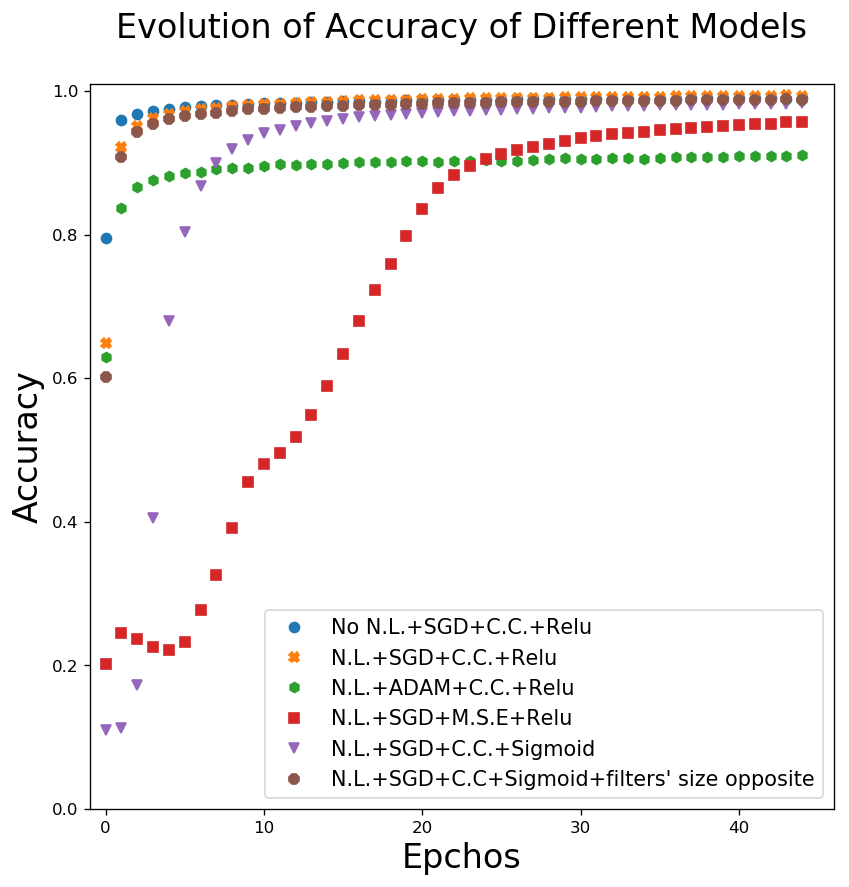

In [197]:
figure_his = plt.figure(figsize=(8,8), dpi = 120)
#plt.plot(model_1_his.history['acc'], model_2_his.history['acc'], model_3_his.history['acc'], model_4_his.history['acc'], 
#         model_5_his.history['acc'], model_6_his.history['acc'])

plt.plot(model_1_his.history['acc'],'o', label='No N.L.+SGD+C.C.+Relu')
plt.plot(model_2_his.history['acc'],'X', label='N.L.+SGD+C.C.+Relu')
plt.plot(model_3_his.history['acc'],'h', label='N.L.+ADAM+C.C.+Relu')
plt.plot(model_4_his.history['acc'],'s', label='N.L.+SGD+M.S.E+Relu')
plt.plot(model_5_his.history['acc'],'v', label='N.L.+SGD+C.C.+Sigmoid')
plt.plot(model_6_his.history['acc'],'8', label='N.L.+SGD+C.C+Sigmoid+filters\' size opposite')
plt.xlabel('Epchos', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xlim(-1,46)
plt.ylim(0,1.01)
plt.legend(loc='best',prop={'size': 12.5})
plt.title('Evolution of Accuracy of Different Models', fontsize=20, y=1.05)
plt.show()

## Conclusion
1. 做了各層 input 的 normalized 後，測試資料準確率有稍微提升。
2. ADAM 的效果好像不太好。
3. 看起來做分類問題 loss 還是用 categorical_crossentropy 比 M.S.E. 好。
4. Relu 的效果比 Sigmoid 好。
5. filter 數目由小到大準確率比大到小些微高一點
 

In [110]:
Cv_1 = Conv2D(2,(4,16), padding = 'same', input_shape = (28,28,1), activation='relu')
Ch_1 = Conv2D(2,(16,4), padding = 'same', input_shape = (28,28,1), activation='relu')
Cs_1 = Conv2D(2,(8,8), padding = 'same', input_shape = (28,28,1), activation='relu')
P_1 = (MaxPool2D(pool_size=(2,2)))

Cv_2 = Conv2D(4,(4,16), padding = 'same', activation='relu')
Ch_2 = Conv2D(4,(16,4), padding = 'same', activation='relu')
Cs_2 = Conv2D(4,(8,8), padding = 'same', activation='relu')
P_2 = (MaxPool2D(pool_size=(2,2)))

Cv_3 = Conv2D(8,(4,16), padding = 'same', activation='relu')
Ch_3 = Conv2D(8,(16,4), padding = 'same', activation='relu')
Cs_3 = Conv2D(8,(8,8), padding = 'same', activation='relu')
P_3 = (MaxPool2D(pool_size=(2,2)))

F_1 = Flatten()
D_1 = Dense(9, activation='relu')
Output = Dense(10, activation='softmax')

v_1 = Cv_1(x)
h_1 = Ch_1(x)
s_1 = Cs_1(x)
L_1 = concatenate([v_1, h_1, s_1])
PL_1 = P_1(L_1)
N_1 = normalized_layer_1(PL_1)

v_2 = Cv_2(N_1)
h_2 = Ch_2(N_1)
s_2 = Cs_2(N_1)
L_2 = concatenate([v_2, h_2, s_2])
PL_2 = P_2(L_2)
N_2 = normalized_layer_2(PL_2)

v_3 = Cv_3(N_2)
h_3 = Ch_3(N_2)
s_3 = Cs_3(N_2)
L_3 = concatenate([v_3, h_3, s_3])
PL_3 = P_3(L_3)
N_3 = normalized_layer_3(PL_3)

f_1 = F_1(N_3)
N_4 = normalized_layer_4(f_1)
d_1 = D_1(N_4)
output = Output(d_1)

In [182]:
model_7th = Model(x,output)
model_7th.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 28, 28, 2)    130         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 28, 28, 2)    130         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 28, 28, 2)    130         input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

### 試試把 filter 加大提高準確率。

In [183]:
model_7th.load_weights('./MNIST_CNN_Machines/CNN_7th_machine_weights.h5')
model_7 = model_7th.compile( optimizers.sgd(lr = 0.05),losses.categorical_crossentropy, metrics=['acc'])
#model_7_his = model_7th.fit(x_train_cnn, y_train_one_hot, batch_size=100, epochs=45)

Epoch 1/45
60000/60000 [==============================] - 273s 5ms/step - loss: 0.8786 - acc: 0.7572
Epoch 2/45
60000/60000 [==============================] - 271s 5ms/step - loss: 0.1550 - acc: 0.9593
Epoch 3/45
60000/60000 [==============================] - 270s 5ms/step - loss: 0.0945 - acc: 0.9740
Epoch 4/45
60000/60000 [==============================] - 285s 5ms/step - loss: 0.0735 - acc: 0.9798
Epoch 5/45
60000/60000 [==============================] - 252s 4ms/step - loss: 0.0607 - acc: 0.9829
Epoch 6/45
60000/60000 [==============================] - 250s 4ms/step - loss: 0.0506 - acc: 0.9855
Epoch 7/45
60000/60000 [==============================] - 250s 4ms/step - loss: 0.0438 - acc: 0.9875
Epoch 8/45
60000/60000 [==============================] - 254s 4ms/step - loss: 0.0388 - acc: 0.9889
Epoch 9/45
60000/60000 [==============================] - 255s 4ms/step - loss: 0.0340 - acc: 0.9906
Epoch 10/45
60000/60000 [==============================] - 252s 4ms/step - loss: 0.0313 - a

In [185]:
#model_7th_json = model_7th.to_json()
#open('./MNIST_CNN_Machines/CNN_7th_machine','w').write(model_7th_json)
#model_7th.save_weights('./MNIST_CNN_Machines/CNN_7th_machine_weights.h5')

訓練資料可以到 99.99% ，測試資料則是 99.17% 。

In [186]:
model_7th_score_train = model_7th.evaluate(x_train_cnn, y_train_one_hot)
model_7th_score_test = model_7th.evaluate(x_test_cnn, y_test_one_hot)
y_7th_predict_one_hot = model_7th.predict(x_test_cnn)
print(f'For Training Data: Loss = {model_7th_score_train[0]:.6f}; Accuracy = {100*model_7th_score_train[1]:.6f}%')
print(f'For Testing Data: Loss = {model_7th_score_test[0]:.6f}; Accuracy = {100*model_7th_score_test[1]:.6f}%')

y_7th_predict = np.zeros(len(y_test)).astype(np.int32)
for i in range(0, len(y_test)):
    y_7th_predict[i] = y_7th_predict_one_hot[i].argmax()
pd.crosstab(y_test, y_7th_predict, rownames=['Ture Number'], colnames=['Predict Number'])

10000/10000 [==============================] - 22s 2ms/step
For Training Data: Loss = 0.001761; Accuracy = 99.998333%
For Testing Data: Loss = 0.028553; Accuracy = 99.170000%


Predict Number,0,1,2,3,4,5,6,7,8,9
Ture Number,,,,,,,,,,
0,974,0,0,0,0,0,3,1,2,0
1,0,1128,2,0,0,1,2,2,0,0
2,2,0,1027,0,0,0,0,3,0,0
3,0,0,0,1002,0,3,0,3,1,1
4,0,0,0,0,977,0,1,0,0,4
5,2,0,0,5,0,882,1,0,0,2
6,4,2,0,0,1,2,948,0,1,0
7,0,4,6,0,0,0,0,1014,1,3
8,2,0,2,0,1,0,0,0,968,1


In [187]:
y_wrong_predict_7th = []
x_wrong_predict_7th = []

for i in range(0,10):
    TF = (y_test==i) &(y_7th_predict!=y_test)
    y_wrong_predict_7th.append(y_7th_predict[TF])
    x_wrong_predict_7th.append(x_test[TF])
    
interact_manual(WRONG_CLASSIFICATION, name=fixed('7^{th}'),
                y_wrong_predict=fixed(y_wrong_predict_7th), x_wrong_predict=fixed(x_wrong_predict_7th),
               number=range(0,10) );

interactive(children=(Dropdown(description='number', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Button(…